In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib.patches import Rectangle
pd.set_option("display.max_rows", 100)

In [2]:
import xml.etree.ElementTree as ET
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import sys
sys.path.append("..")

In [4]:
from bbox.connectors import SfMComponents, BBoxComponents
from bbox.bbox_transformations import bbox_to_global, img_to_global_coord
from bbox.io_utils import ParseXML

In [5]:
base_path = "/home/chinmays/Documents/PSI_Research/data/exports/good_data/reference"
connector = SfMComponents(base_path)
gcp_reference = connector.gcp_reference
camera_reference = connector.camera_reference
image_path = "/home/chinmays/Documents/PSI_Research/data/exports/good_data/circular_12bit_referenced_dataset/"

In [6]:
PITCH_THRESH = 30.
YAW_THRESH = 360

In [7]:
annotation_file_path = "/home/chinmays/Documents/PSI_Research/data/exports/good_data/annotations"

In [8]:
reader = ParseXML(image_path=image_path, label_path=annotation_file_path)

In [9]:
box_connector = BBoxComponents(reader, image_path, annotation_file_path)

In [10]:
imgs = box_connector.images
imgs = [
    img for img in imgs 
    if float(camera_reference[
        (camera_reference["label"] == img.id)
    ]["Estimated_Pitch"].abs()) < PITCH_THRESH
    and
    float(camera_reference[
        (camera_reference["label"] == img.id)
    ]["Estimated_Yaw"].abs()) < YAW_THRESH
]
len(imgs)

57

In [11]:
label_files = os.listdir(annotation_file_path)

In [12]:
target_store = dict()
targets = dict()
marker_labels = dict()
targets_image = dict()

for xml_file in label_files:
    image_id = xml_file.split(".")[0]
    
    file = os.path.join(annotation_file_path, xml_file)
    
    _marker_labels = []
    _targets = []
    _targets_image = []

    tree = ET.parse(file)
    root = tree.getroot()

    for item in root.findall("size"):
        image_width = int(item.findall("width")[0].text)
        image_height = int(item.findall("height")[0].text)

    for items in root.findall("object"):
        for item in items.findall("name"):
            marker_label = f"target {item.text}"
            target_x = float(gcp_reference[gcp_reference["label"] == marker_label]["Reference_X"])
            target_y = float(gcp_reference[gcp_reference["label"] == marker_label]["Reference_Y"])
            target = np.array([target_x, target_y])
            
            stored_targets = target_store.get(marker_label, None)
            if stored_targets is None: target_store[marker_label] = target
            
            _targets.append(target)
            _marker_labels.append(marker_label)

        for item in items.findall("bndbox"):
            xmin = int(item.findall("xmin")[0].text)
            xmax = int(item.findall("xmax")[0].text)
            ymin = int(item.findall("ymin")[0].text)
            ymax = int(item.findall("ymax")[0].text)

            top_right = [xmax, ymin]
            bottom_left = [xmin, ymax]
            top_left = [xmin, ymin]
            bottom_right = [xmax, ymax]

            target_x_image = xmin + (xmax - xmin)/2
            target_y_image = ymin + (ymax - ymin)/2
            target_coordinates_image = np.array([target_x_image, target_y_image])

            _targets_image.append(target_coordinates_image)
            
    targets[image_id] = {lb: coord for lb, coord in zip(_marker_labels, _targets)}
    marker_labels[image_id] = _marker_labels
    targets_image[image_id] = _targets_image

In [13]:
pixel_height = 0.00753331989370232
pixel_width = 0.00753331989370232

In [14]:
results = dict()
camera_centers = dict()
for image in imgs:
    
    camera_label = image.id
    
    yaw_angle = float(camera_reference[camera_reference["label"] == camera_label]["Estimated_Yaw"])
    pitch_angle = float(camera_reference[camera_reference["label"] == camera_label]["Estimated_Pitch"])
    roll_angle = float(camera_reference[camera_reference["label"] == camera_label]["Estimated_Roll"])
    
    focal_length = float(camera_reference[camera_reference["label"] == camera_label]["f"])
    camera_height = float(camera_reference[camera_reference["label"] == camera_label]["Estimated_Z"])
    camera_x = float(camera_reference[camera_reference["label"] == camera_label]["Estimated_X"])
    camera_y = float(camera_reference[camera_reference["label"] == camera_label]["Estimated_Y"])
    camera_center = [camera_x, camera_y]
    
    camera_centers[camera_label] = camera_center
    
    global_coordinates = dict()
    for bbox in image.bboxes.bboxes:
        gt = targets[camera_label][bbox.cls]
        
        top_left = bbox.local_coordinates.top_left
        bottom_left = bbox.local_coordinates.bottom_left
        top_right = bbox.local_coordinates.top_right
        bottom_right = bbox.local_coordinates.bottom_right
        
        # Transformation
        global_top_left, global_top_right, global_bottom_left, global_bottom_right = bbox_to_global(
            top_left, top_right, bottom_left, bottom_right, 
            camera_center, pixel_width, pixel_height, focal_length, 
            image_width, image_height, camera_height, 
            yaw_angle, pitch_angle, roll_angle
        )
        
        global_coordinates[bbox.cls] = {
            "top_left": global_top_left,
            "top_right": global_top_right,
            "bottom_left": global_bottom_left,
            "bottom_right": global_bottom_right
        }
    results[camera_label] = global_coordinates
    

In [15]:
inverse_results = dict()
for camera_id, glb_coords in results.items():
    for target_id, coords in glb_coords.items():
        try:
            inverse_results[target_id][camera_id] = coords
        except Exception:
            inverse_results[target_id] = {camera_id: coords}

In [16]:

def print_coords(global_coords):
    print("Top Left", global_coords["top_left"])
    print("Top Right", global_coords["top_right"])
    print("Bottom Left", global_coords["bottom_left"])
    print("Bottom Right", global_coords["bottom_right"])

def plot_vertices(coords, ax):
    ax.scatter(coords["top_left"][0], coords["top_left"][1], c="r") # Top Left
    ax.scatter(coords["top_right"][0], coords["top_right"][1], c="g") # Top Right
    ax.scatter(coords["bottom_left"][0], coords["bottom_left"][1], c="b") # Bottom Left
    ax.scatter(coords["bottom_right"][0], coords["bottom_right"][1], c="y") # Bottom Right
    
def plot_rectangle(centers, global_coords, colors=None, targets=[]):
    
    import random
    random.seed(424242)
    
    pairs = set()
    if len(global_coords) == 1:
        lb1 = list(global_coords.keys())[0]
        pitch1 = float(camera_reference[camera_reference["label"] == lb1]["Estimated_Pitch"])
        roll1 = float(camera_reference[camera_reference["label"] == lb1]["Estimated_Roll"])
#         print(f"Pitch - {lb1}: {pitch1}\nRoll - {lb1}: {roll1}")
    for lb1, box1 in global_coords.items():
        for lb2, box2 in global_coords.items():
            if lb1 == lb2:
                continue
            key = ",".join(sorted((lb1,lb2)))
            pitch1 = float(camera_reference[camera_reference["label"] == lb1]["Estimated_Pitch"])
            pitch2 = float(camera_reference[camera_reference["label"] == lb2]["Estimated_Pitch"])
            roll1 = float(camera_reference[camera_reference["label"] == lb1]["Estimated_Roll"])
            roll2 = float(camera_reference[camera_reference["label"] == lb2]["Estimated_Roll"])
            
            if key in pairs:
                continue
#             printstr = f"Pitch - {lb1}: {pitch1}, {lb2}: {pitch2}"
#             printstr += f"\nRoll - {lb1}: {roll1}, {lb2}: {roll2}"
            printstr = ""
            iou = bb_iou(box1, box2)
            printstr += f"IOU - {lb1}, {lb2}: {iou}"
            print(printstr)
            pairs.add(key)
    
    f, ax = plt.subplots(1, 1, dpi=300)
    ax.set_aspect("equal", adjustable="box")
    
    cameras = global_coords.keys()
    handles = []
    labels = []
    for camera in cameras: # center in centers:
        r, g, b = random.random(), random.random(), random.random()
        color = (r, g, b)
        
        _center = centers[camera]
        
        handle = ax.scatter(_center[0], _center[1], marker="x", color=color)
        
        global_coord = global_coords[camera]
        anchor = tuple(global_coord["bottom_left"])
        width = global_coord["top_right"][0] - global_coord["top_left"][0]
        height = global_coord["top_left"][1] - global_coord["bottom_left"][1]
        patch = Rectangle(anchor, width, height, facecolor="none", edgecolor=color, linewidth=1)
        ax.add_patch(patch)
        handles.append(handle)
        pitch1 = float(camera_reference[camera_reference["label"] == camera]["Estimated_Pitch"])
        roll1 = float(camera_reference[camera_reference["label"] == camera]["Estimated_Roll"])
        yaw1 = float(camera_reference[camera_reference["label"] == camera]["Estimated_Yaw"])
        label = camera + " Yaw: {:.4f}, Pitch: {:.4f}, Roll: {:.4f}".format(yaw1, pitch1, roll1)
        labels.append(label)
    
    target_colors = ["r", "c", "y"]

    if targets:
        for t, target in enumerate(targets):
            handle = ax.scatter(target[0], target[1], marker="*", c=target_colors[t])

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.legend(handles, labels, ncol=2, loc="lower left", fontsize="xx-small", bbox_to_anchor=(0.8, 1.0))
    
    plt.show()
    
def bb_iou(_boxA, _boxB):
    
    boxA = [_boxA["top_left"][0], -_boxA["top_left"][1], _boxA["bottom_right"][0], -_boxA["bottom_right"][1]]
    boxB = [_boxB["top_left"][0], -_boxB["top_left"][1], _boxB["bottom_right"][0], -_boxB["bottom_right"][1]]
    
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
    if interArea == 0:
        return 0
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = abs((boxA[2] - boxA[0]) * (boxA[3] - boxA[1]))
    boxBArea = abs((boxB[2] - boxB[0]) * (boxB[3] - boxB[1]))

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

IOU - DSC05628, DSC05621: 0.5359513090955681
IOU - DSC05628, DSC05623: 0.8120165175056963
IOU - DSC05628, DSC05622: 0.6210528656825933
IOU - DSC05628, DSC05627: 0.9022282308262062
IOU - DSC05621, DSC05623: 0.67166494915608
IOU - DSC05621, DSC05622: 0.8641280902896591
IOU - DSC05621, DSC05627: 0.549806840553587
IOU - DSC05623, DSC05622: 0.7740031348435313
IOU - DSC05623, DSC05627: 0.8204046738375923
IOU - DSC05622, DSC05627: 0.6349513386759926


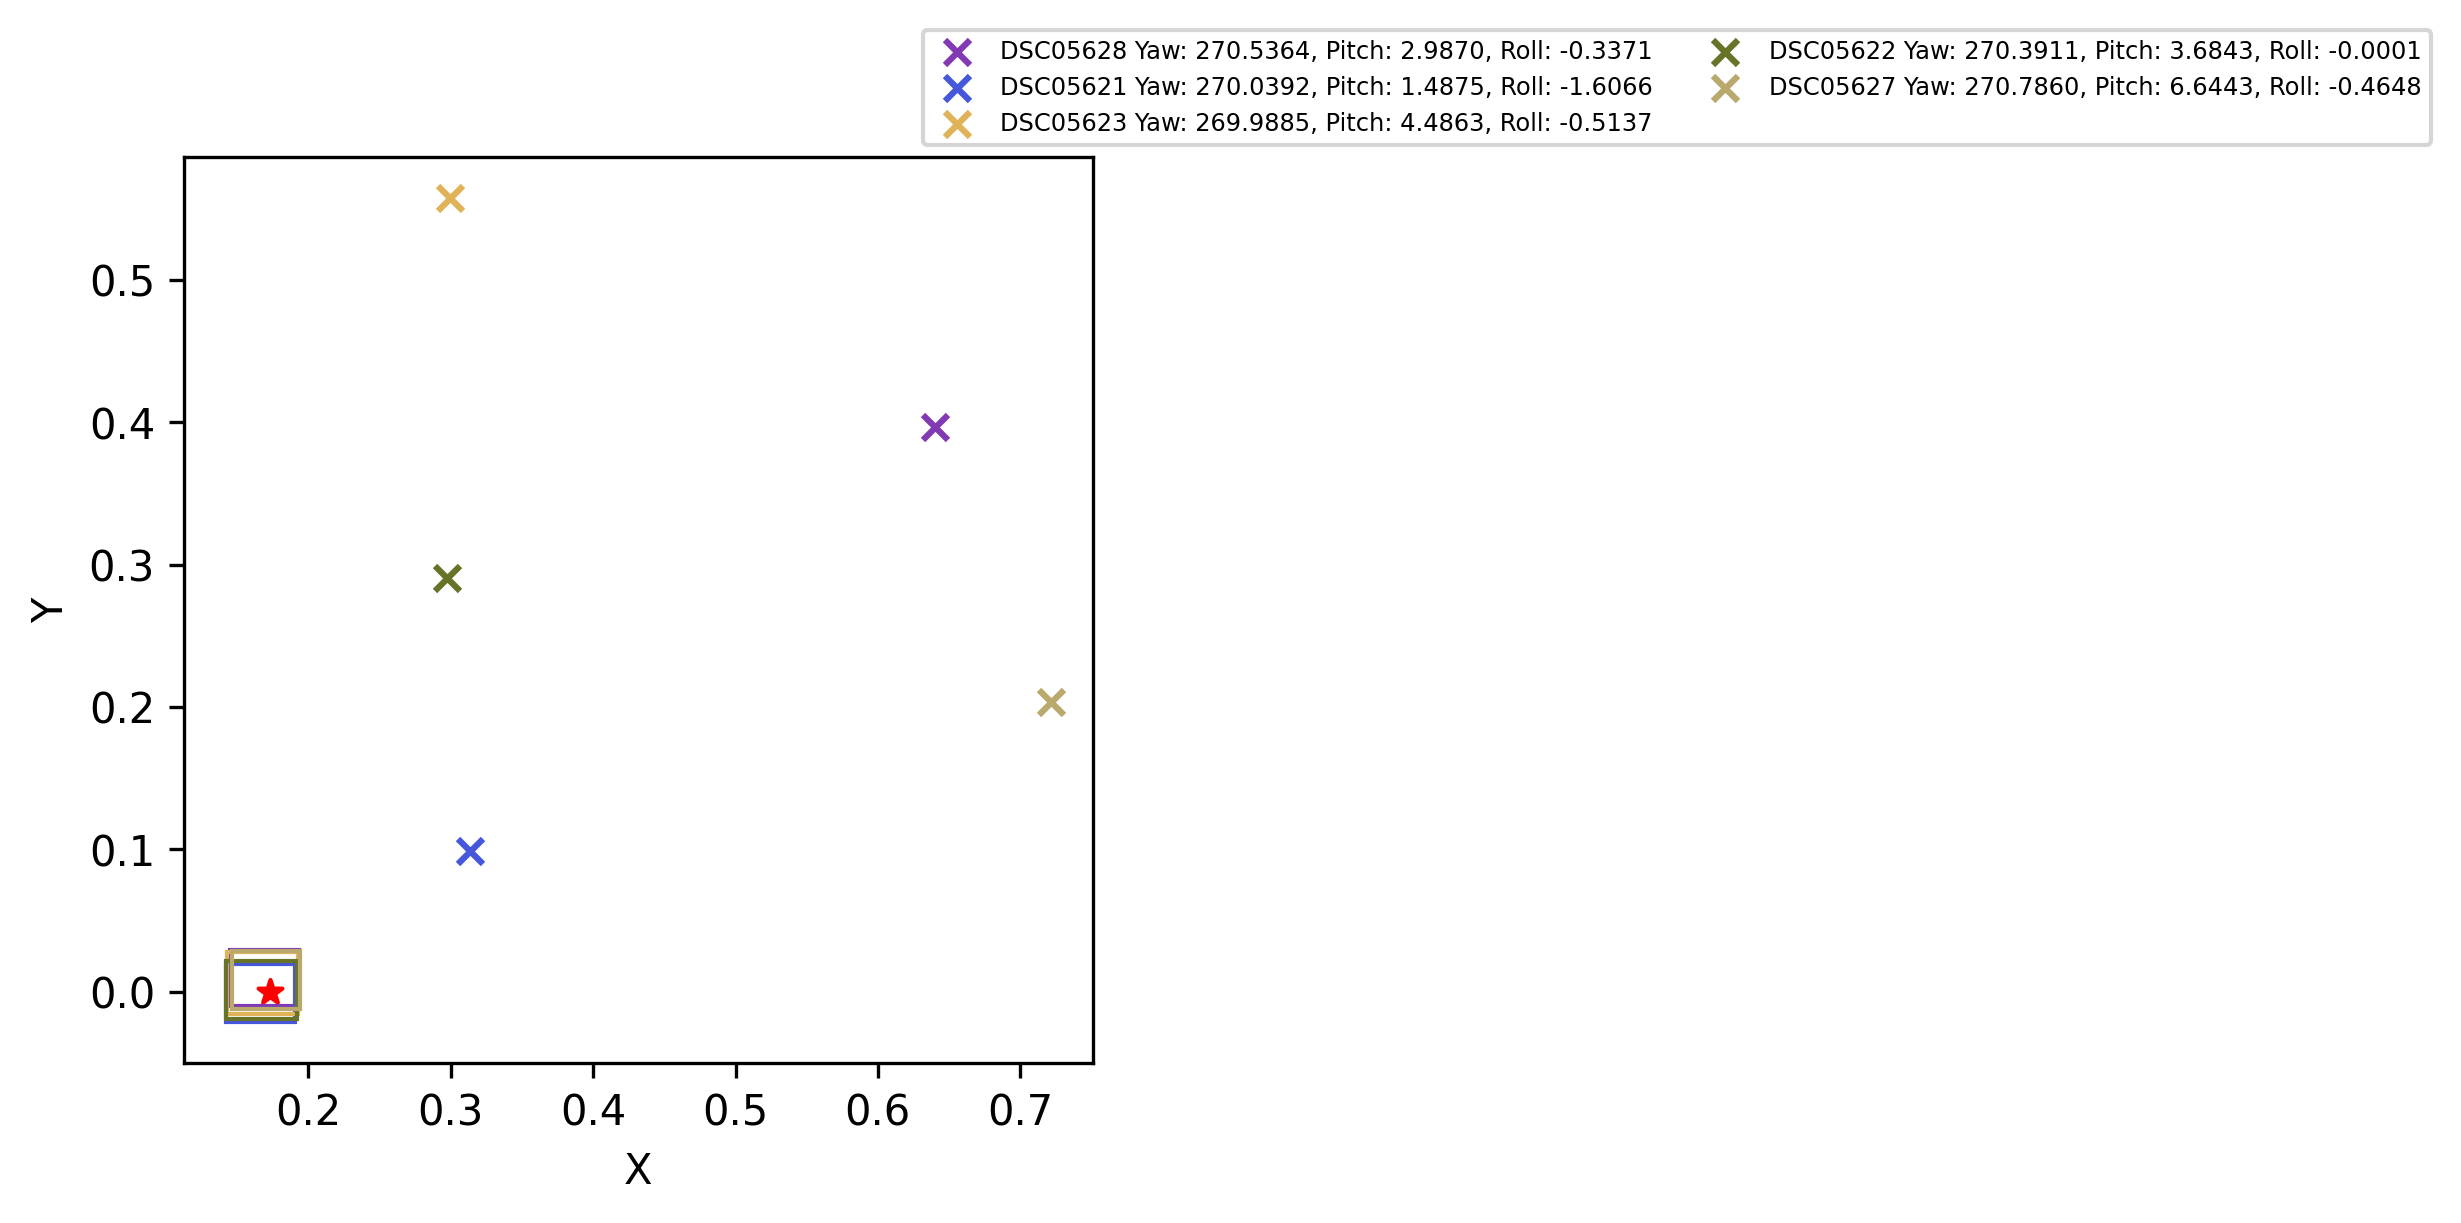

In [17]:
target_to_plot = "target 1"
plot_rectangle(camera_centers, inverse_results[target_to_plot], colors=["r", "g", "b"], targets=[target_store[target_to_plot]])

IOU - DSC05633, DSC05638: 0.6153491063386213
IOU - DSC05633, DSC05632: 0.8750171026299005
IOU - DSC05633, DSC05634: 0.6216449375189189
IOU - DSC05633, DSC05637: 0.4735460304740001
IOU - DSC05633, DSC05631: 0.8195085695765917
IOU - DSC05638, DSC05632: 0.5438101629894178
IOU - DSC05638, DSC05634: 0.8022942090266943
IOU - DSC05638, DSC05637: 0.7460890350990482
IOU - DSC05638, DSC05631: 0.5063899429196587
IOU - DSC05632, DSC05634: 0.5613680561753449
IOU - DSC05632, DSC05637: 0.42072784646170314
IOU - DSC05632, DSC05631: 0.9134608889436528
IOU - DSC05634, DSC05637: 0.717893056464767
IOU - DSC05634, DSC05631: 0.5195350454494714
IOU - DSC05637, DSC05631: 0.3907046158696466


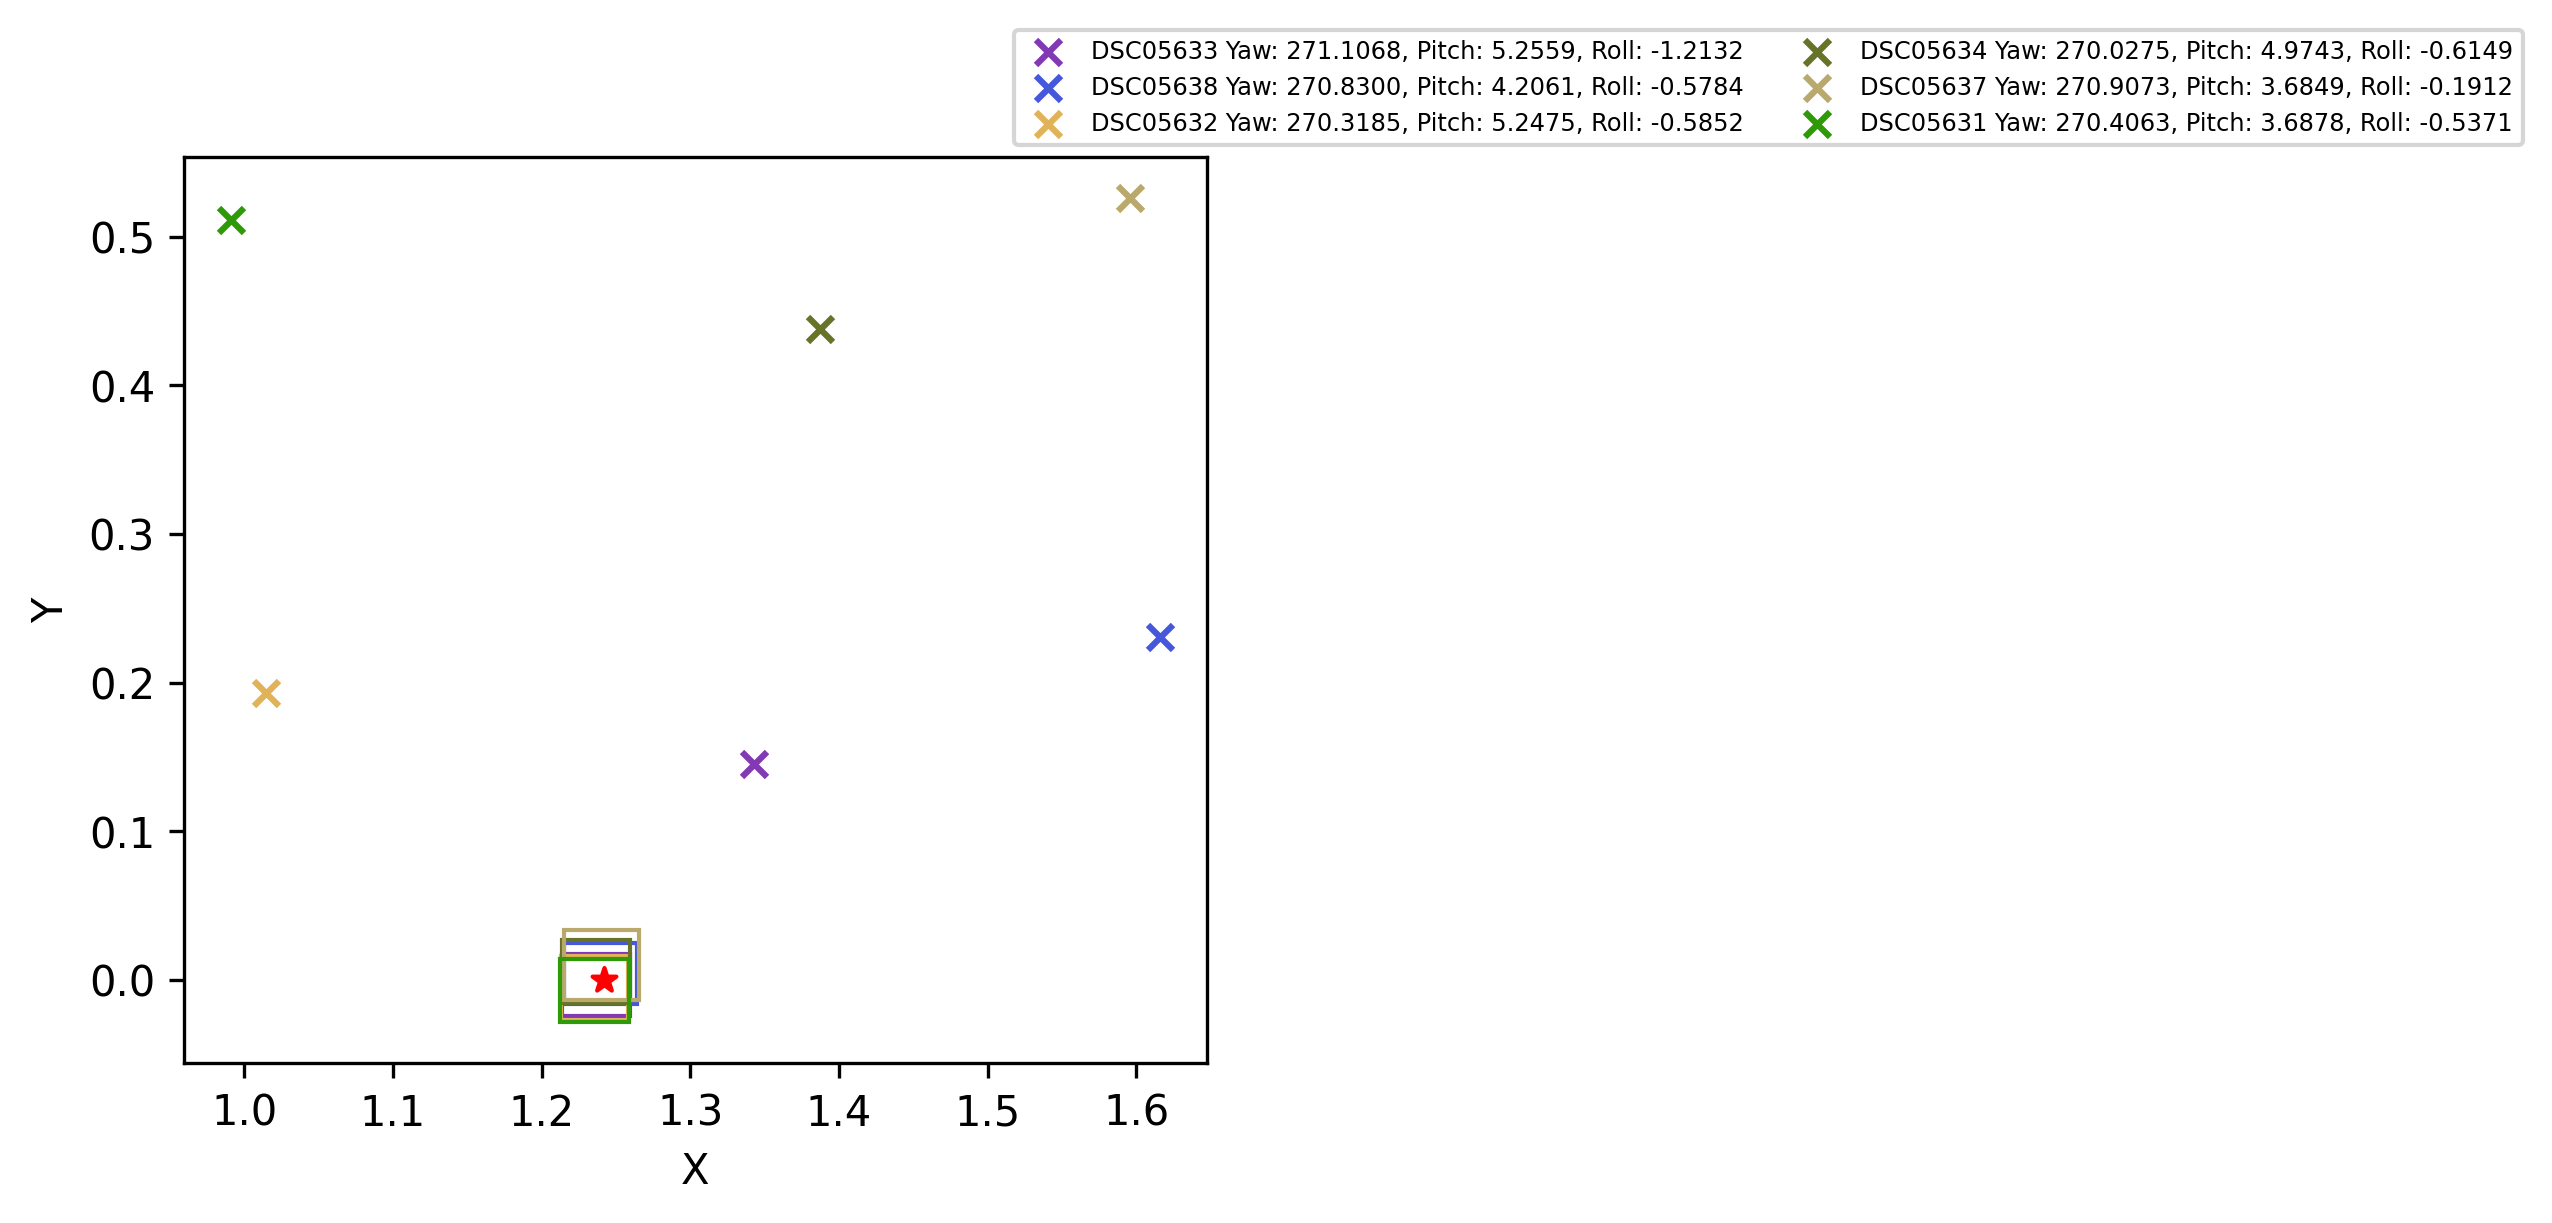

In [18]:
target_to_plot = "target 2"
plot_rectangle(camera_centers, inverse_results[target_to_plot], colors=["r", "g", "b"], targets=[target_store[target_to_plot]])

IOU - DSC05643, DSC05650: 0.6246322833944599
IOU - DSC05643, DSC05646: 0.7403726867312085
IOU - DSC05643, DSC05644: 0.8800984767106292
IOU - DSC05643, DSC05645: 0.7714444235229987
IOU - DSC05643, DSC05649: 0.5624020759918592
IOU - DSC05650, DSC05646: 0.8429842882657159
IOU - DSC05650, DSC05644: 0.560294489787853
IOU - DSC05650, DSC05645: 0.7440145474971629
IOU - DSC05650, DSC05649: 0.8453461339567298
IOU - DSC05646, DSC05644: 0.6620360473894094
IOU - DSC05646, DSC05645: 0.8714176488490117
IOU - DSC05646, DSC05649: 0.7565920999153783
IOU - DSC05644, DSC05645: 0.7454122658266292
IOU - DSC05644, DSC05649: 0.5054377893641099
IOU - DSC05645, DSC05649: 0.6693905489743751


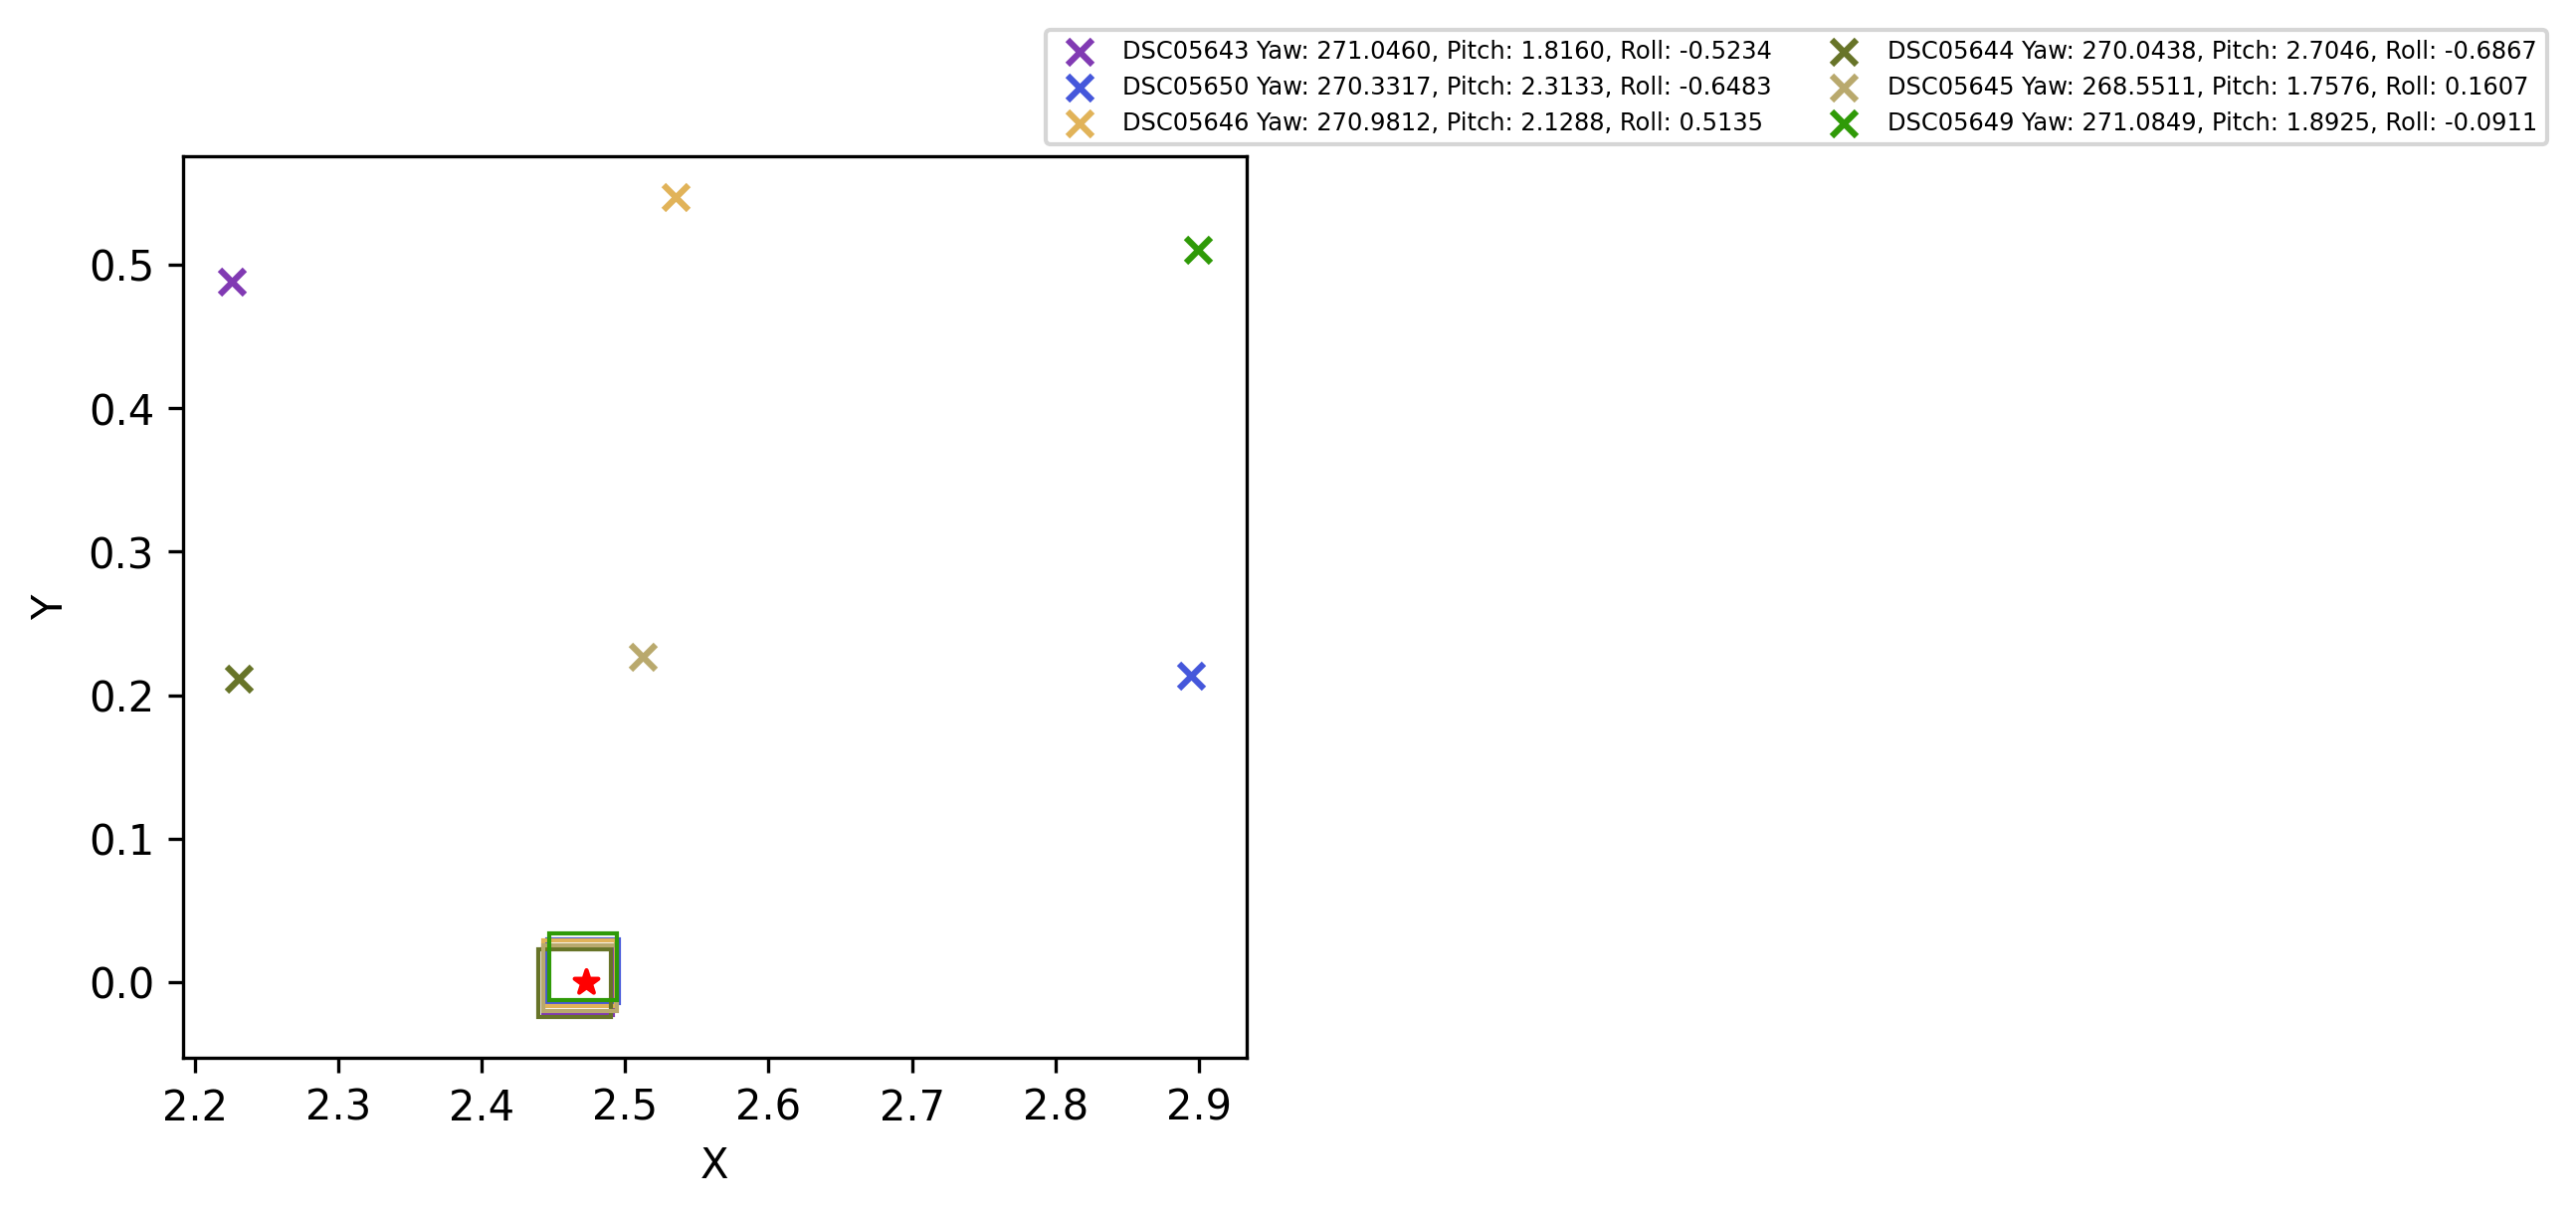

In [19]:
target_to_plot = "target 3"
plot_rectangle(camera_centers, inverse_results[target_to_plot], colors=["r", "g", "b"], targets=[target_store[target_to_plot]])

IOU - DSC05655, DSC05657: 0.7649118028569335
IOU - DSC05655, DSC05658: 0.708908310110326
IOU - DSC05655, DSC05656: 0.8051024263286387
IOU - DSC05657, DSC05658: 0.83906477736277
IOU - DSC05657, DSC05656: 0.7174593583946306
IOU - DSC05658, DSC05656: 0.615968338664021


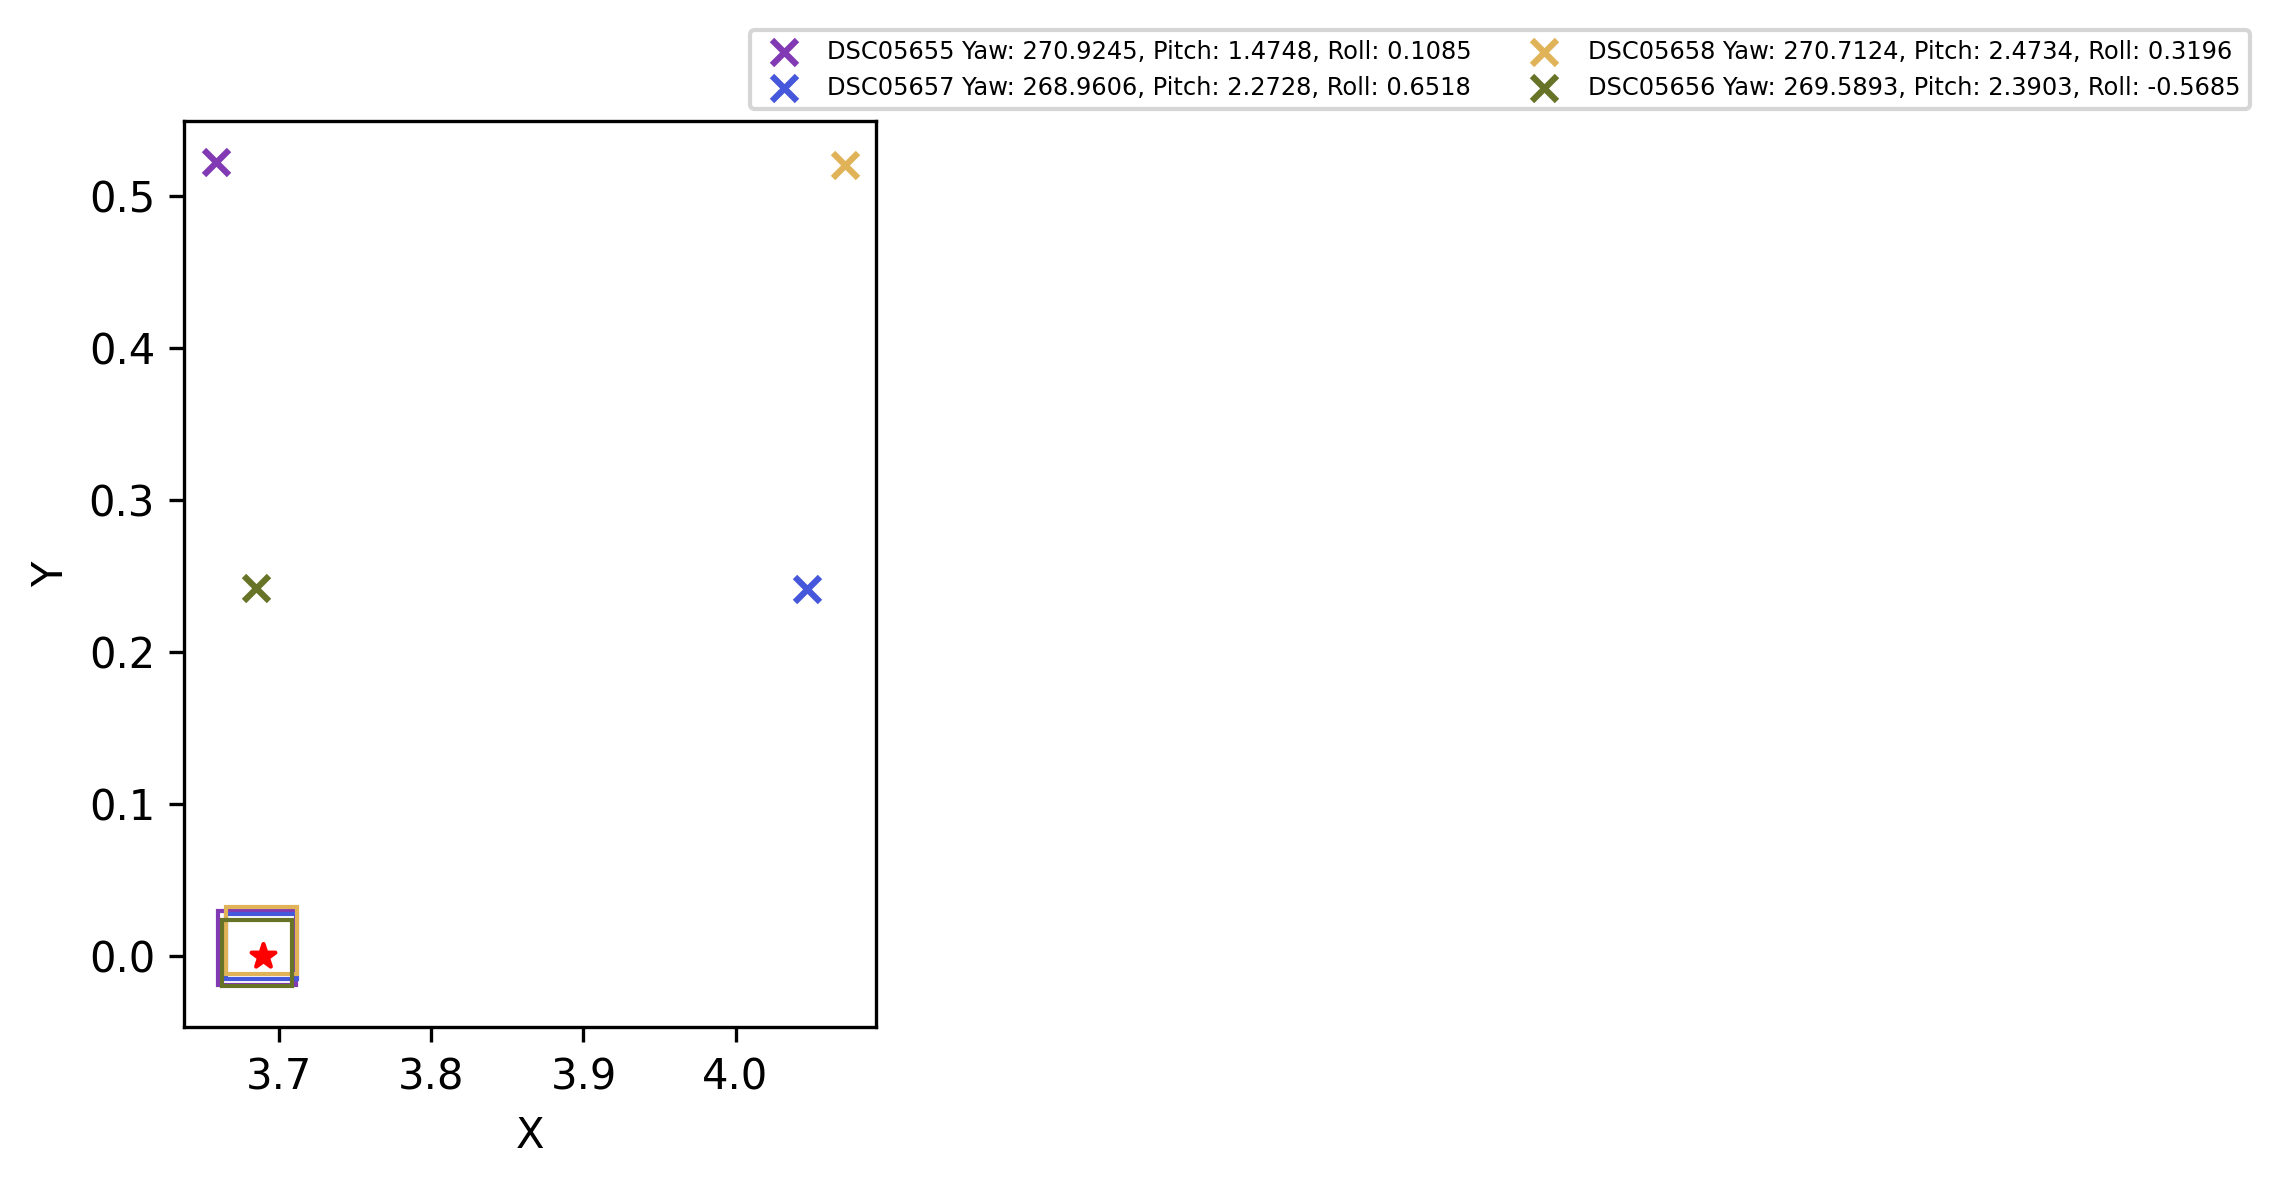

In [20]:
target_to_plot = "target 4"
plot_rectangle(camera_centers, inverse_results[target_to_plot], colors=["r", "g", "b"], targets=[target_store[target_to_plot]])

IOU - DSC05667, DSC05670: 0.5546661688300811
IOU - DSC05667, DSC05669: 0.4568902892944686
IOU - DSC05667, DSC05668: 0.5955496092302693
IOU - DSC05670, DSC05669: 0.8175979542235547
IOU - DSC05670, DSC05668: 0.7485521322176576
IOU - DSC05669, DSC05668: 0.7273657367808759


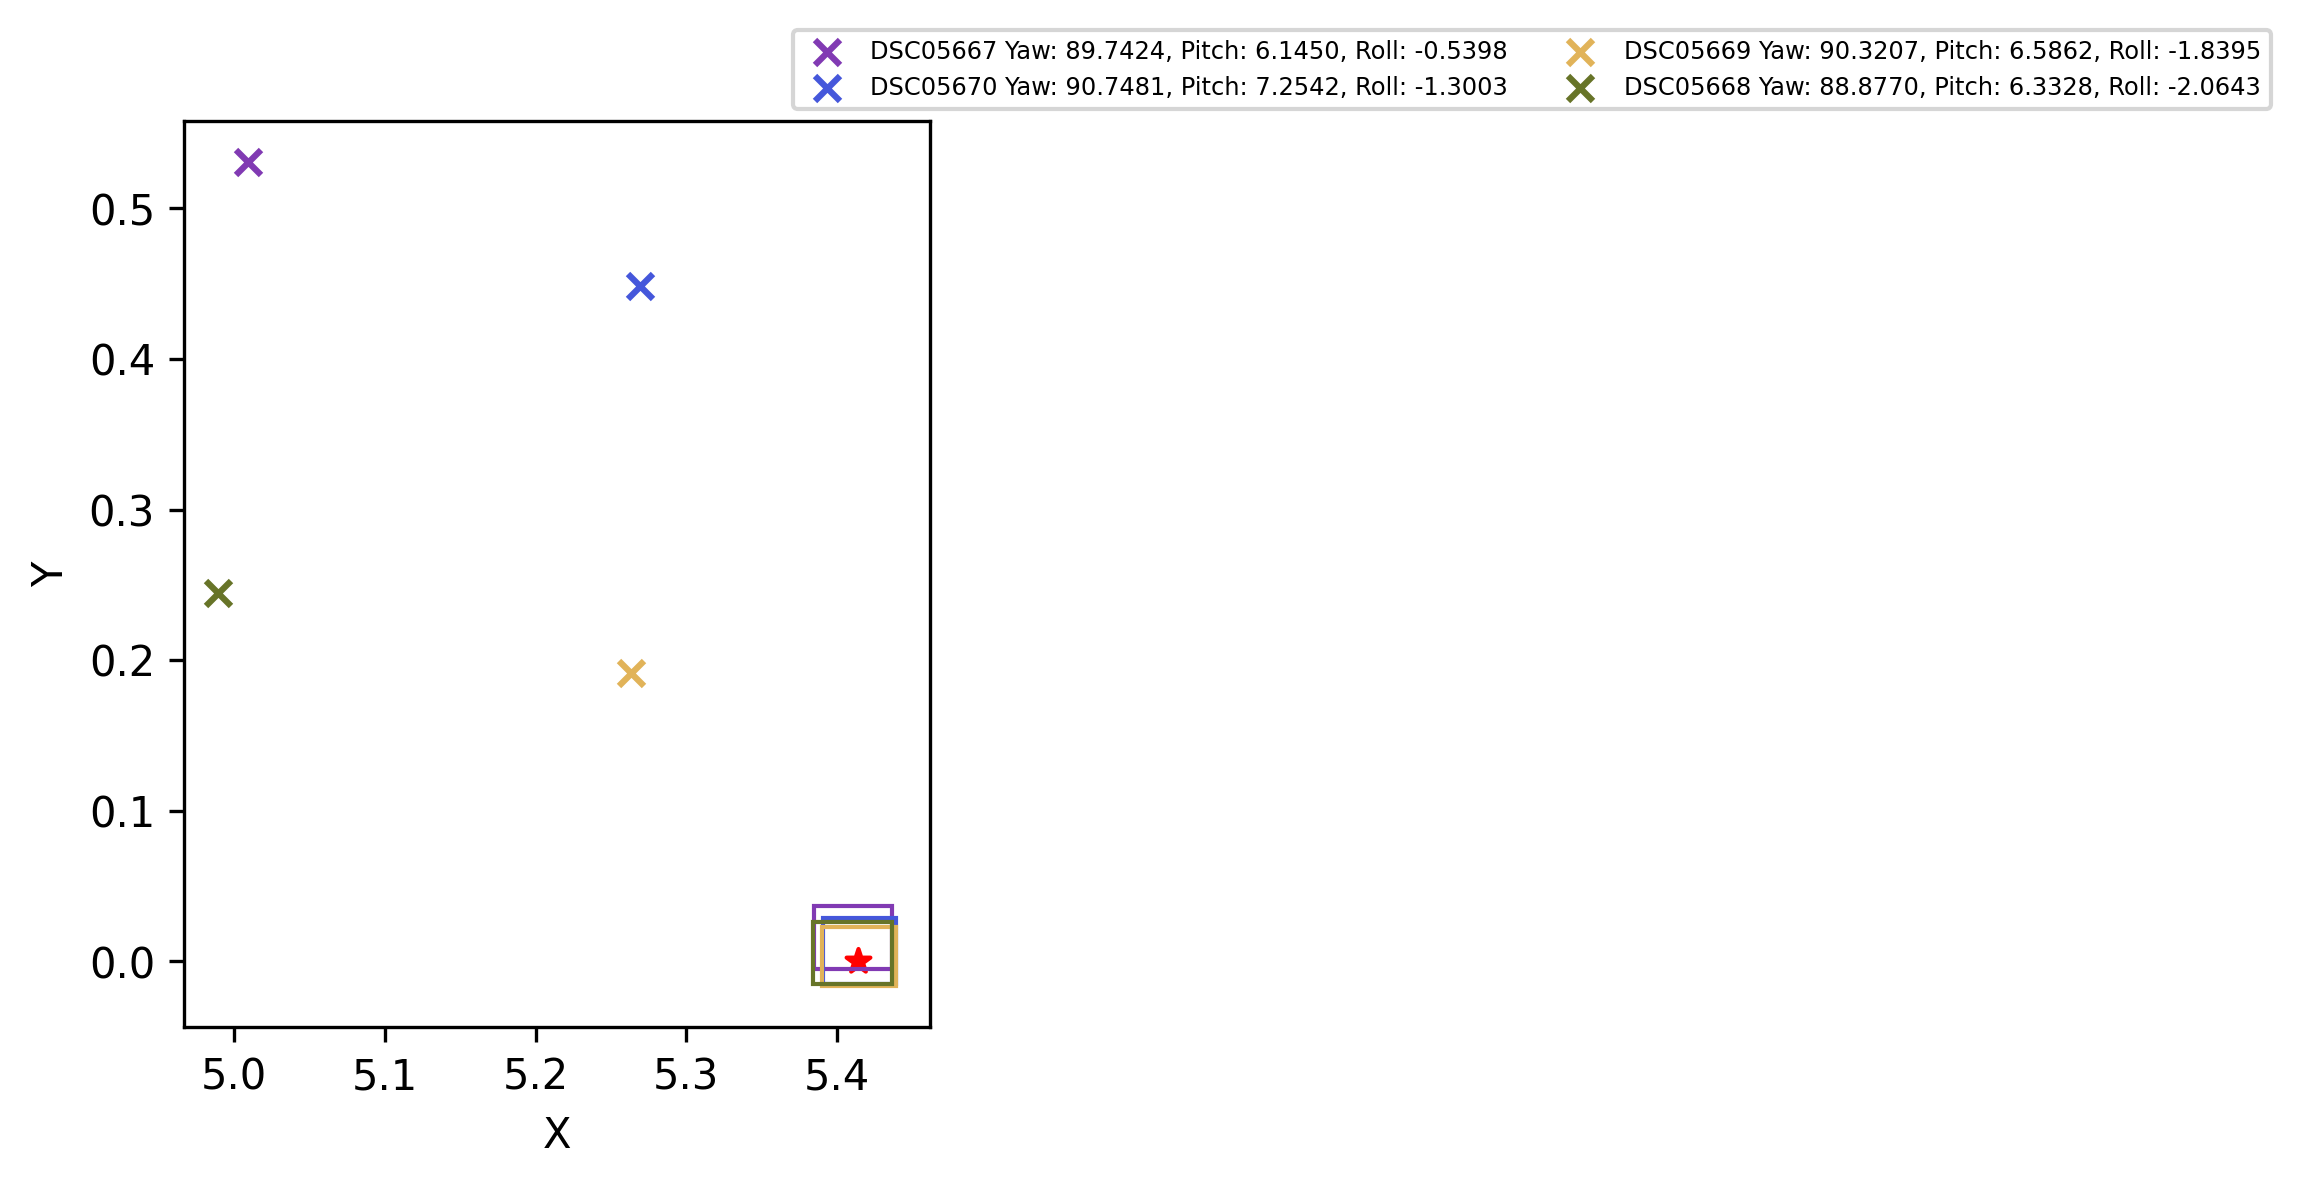

In [21]:
target_to_plot = "target 5"
plot_rectangle(camera_centers, inverse_results[target_to_plot], colors=["r", "g", "b"], targets=[target_store[target_to_plot]])

IOU - DSC05624, DSC05623: 0.8154971674742504
IOU - DSC05624, DSC05622: 0.5536608561385631
IOU - DSC05623, DSC05622: 0.6511306662930656


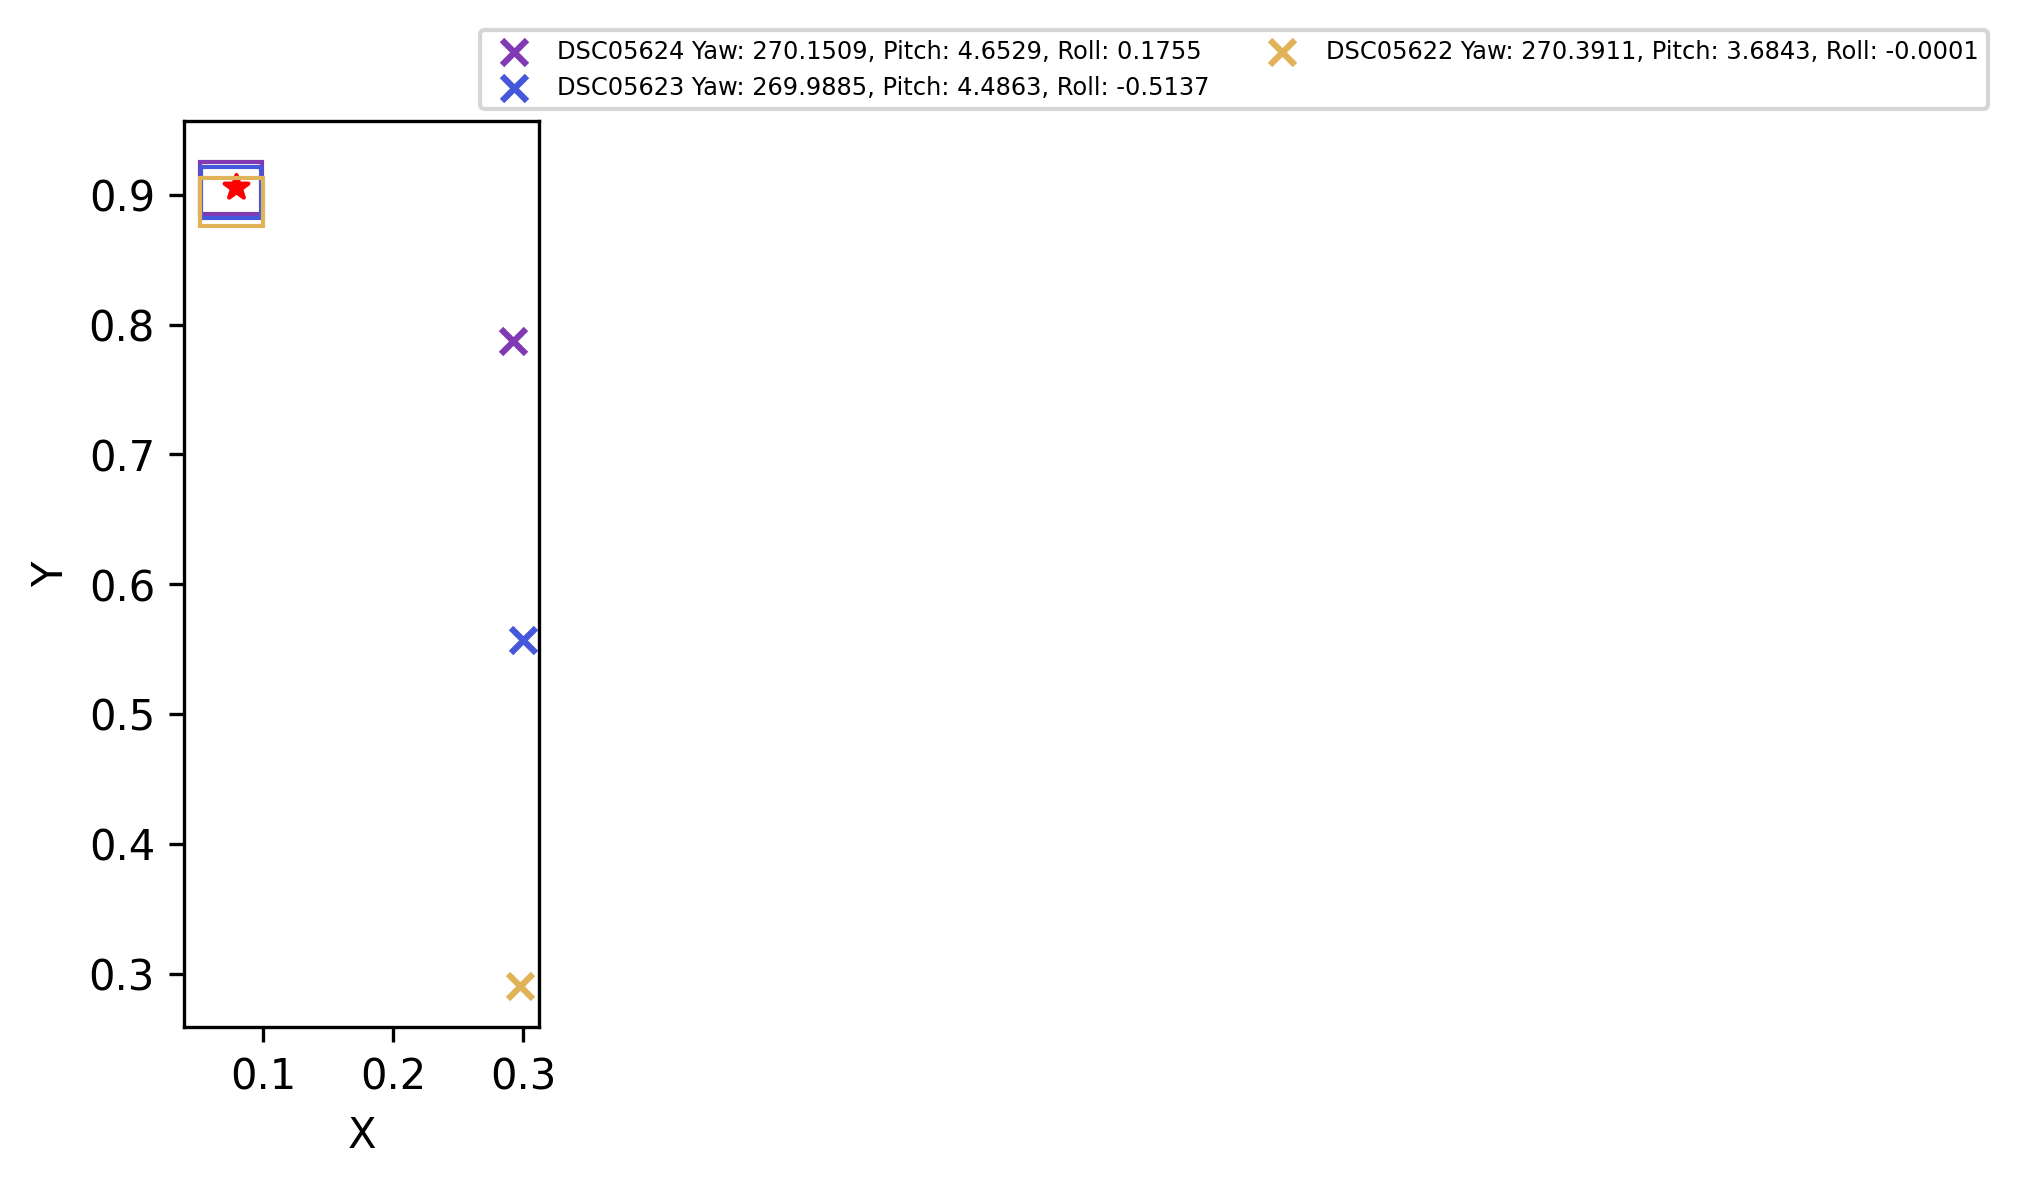

In [22]:
target_to_plot = "target 6"
plot_rectangle(camera_centers, inverse_results[target_to_plot], colors=["r", "g", "b"], targets=[target_store[target_to_plot]])

IOU - DSC05643, DSC05636: 0.7384212298174088
IOU - DSC05643, DSC05642: 0.8523749156681276
IOU - DSC05643, DSC05641: 0.8764181612669005
IOU - DSC05643, DSC05637: 0.6758101948022864
IOU - DSC05643, DSC05640: 0.9134781403902226
IOU - DSC05636, DSC05642: 0.7696571772186922
IOU - DSC05636, DSC05641: 0.8457957947676039
IOU - DSC05636, DSC05637: 0.8694714802871739
IOU - DSC05636, DSC05640: 0.7882596354045658
IOU - DSC05642, DSC05641: 0.8444515642545327
IOU - DSC05642, DSC05637: 0.711412205232397
IOU - DSC05642, DSC05640: 0.8421390515758695
IOU - DSC05641, DSC05637: 0.7580893405687533
IOU - DSC05641, DSC05640: 0.9250395764155549
IOU - DSC05637, DSC05640: 0.7227357967076238


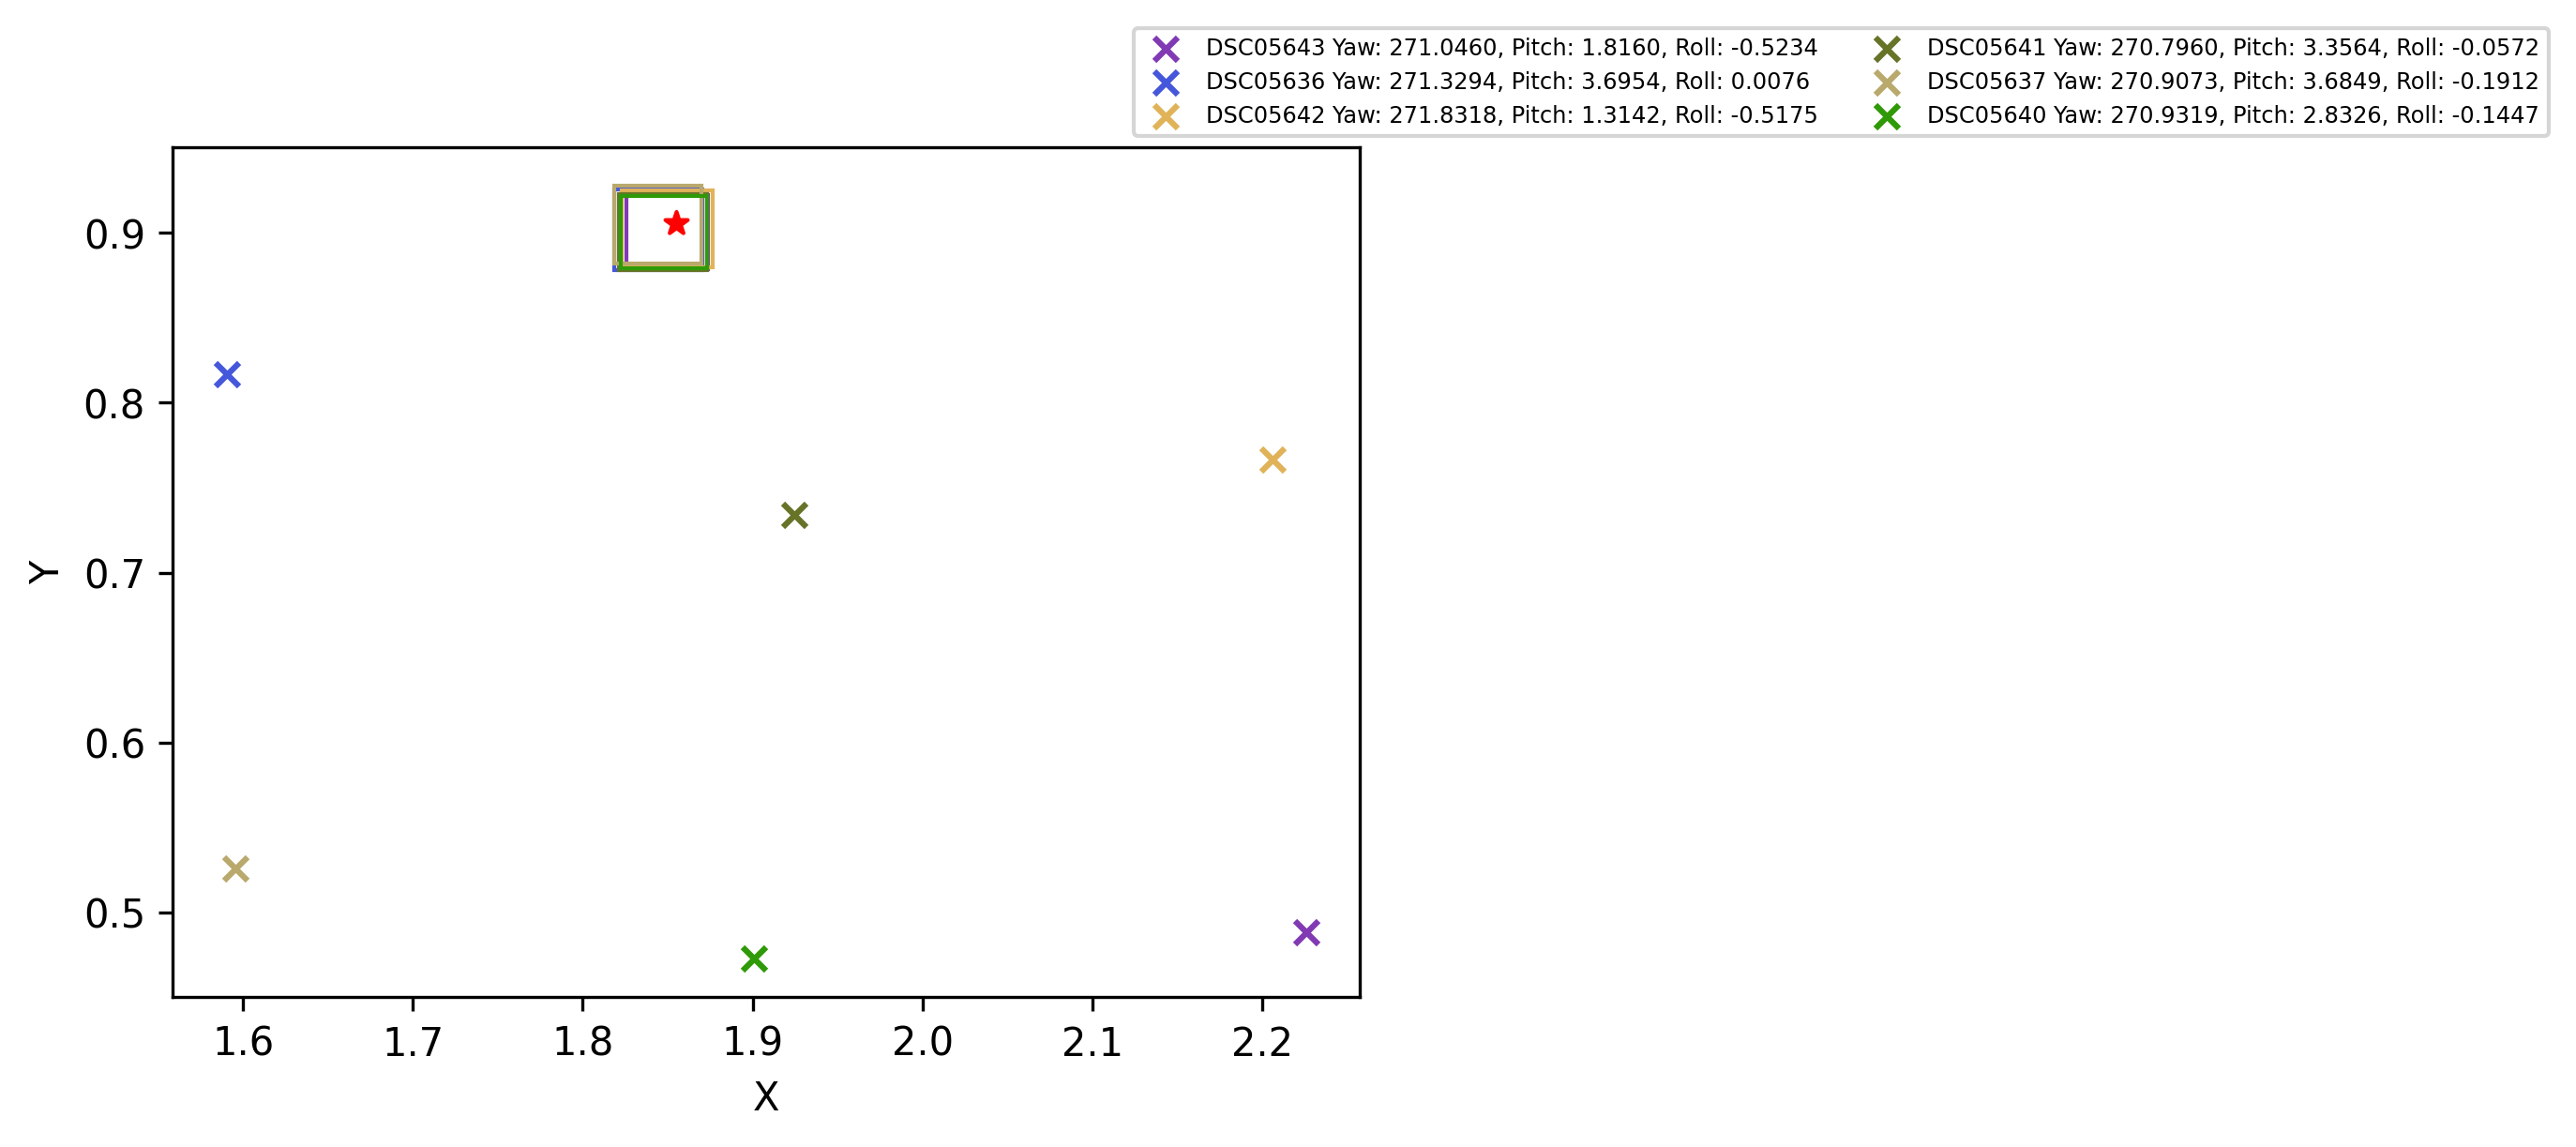

In [23]:
target_to_plot = "target 7"
plot_rectangle(camera_centers, inverse_results[target_to_plot], colors=["r", "g", "b"], targets=[target_store[target_to_plot]])

IOU - DSC05653, DSC05652: 0.7610378940033095
IOU - DSC05653, DSC05648: 0.8330935635949761
IOU - DSC05653, DSC05649: 0.7896688541057137
IOU - DSC05652, DSC05648: 0.7539735860663209
IOU - DSC05652, DSC05649: 0.7186265410908207
IOU - DSC05648, DSC05649: 0.9057744310488285


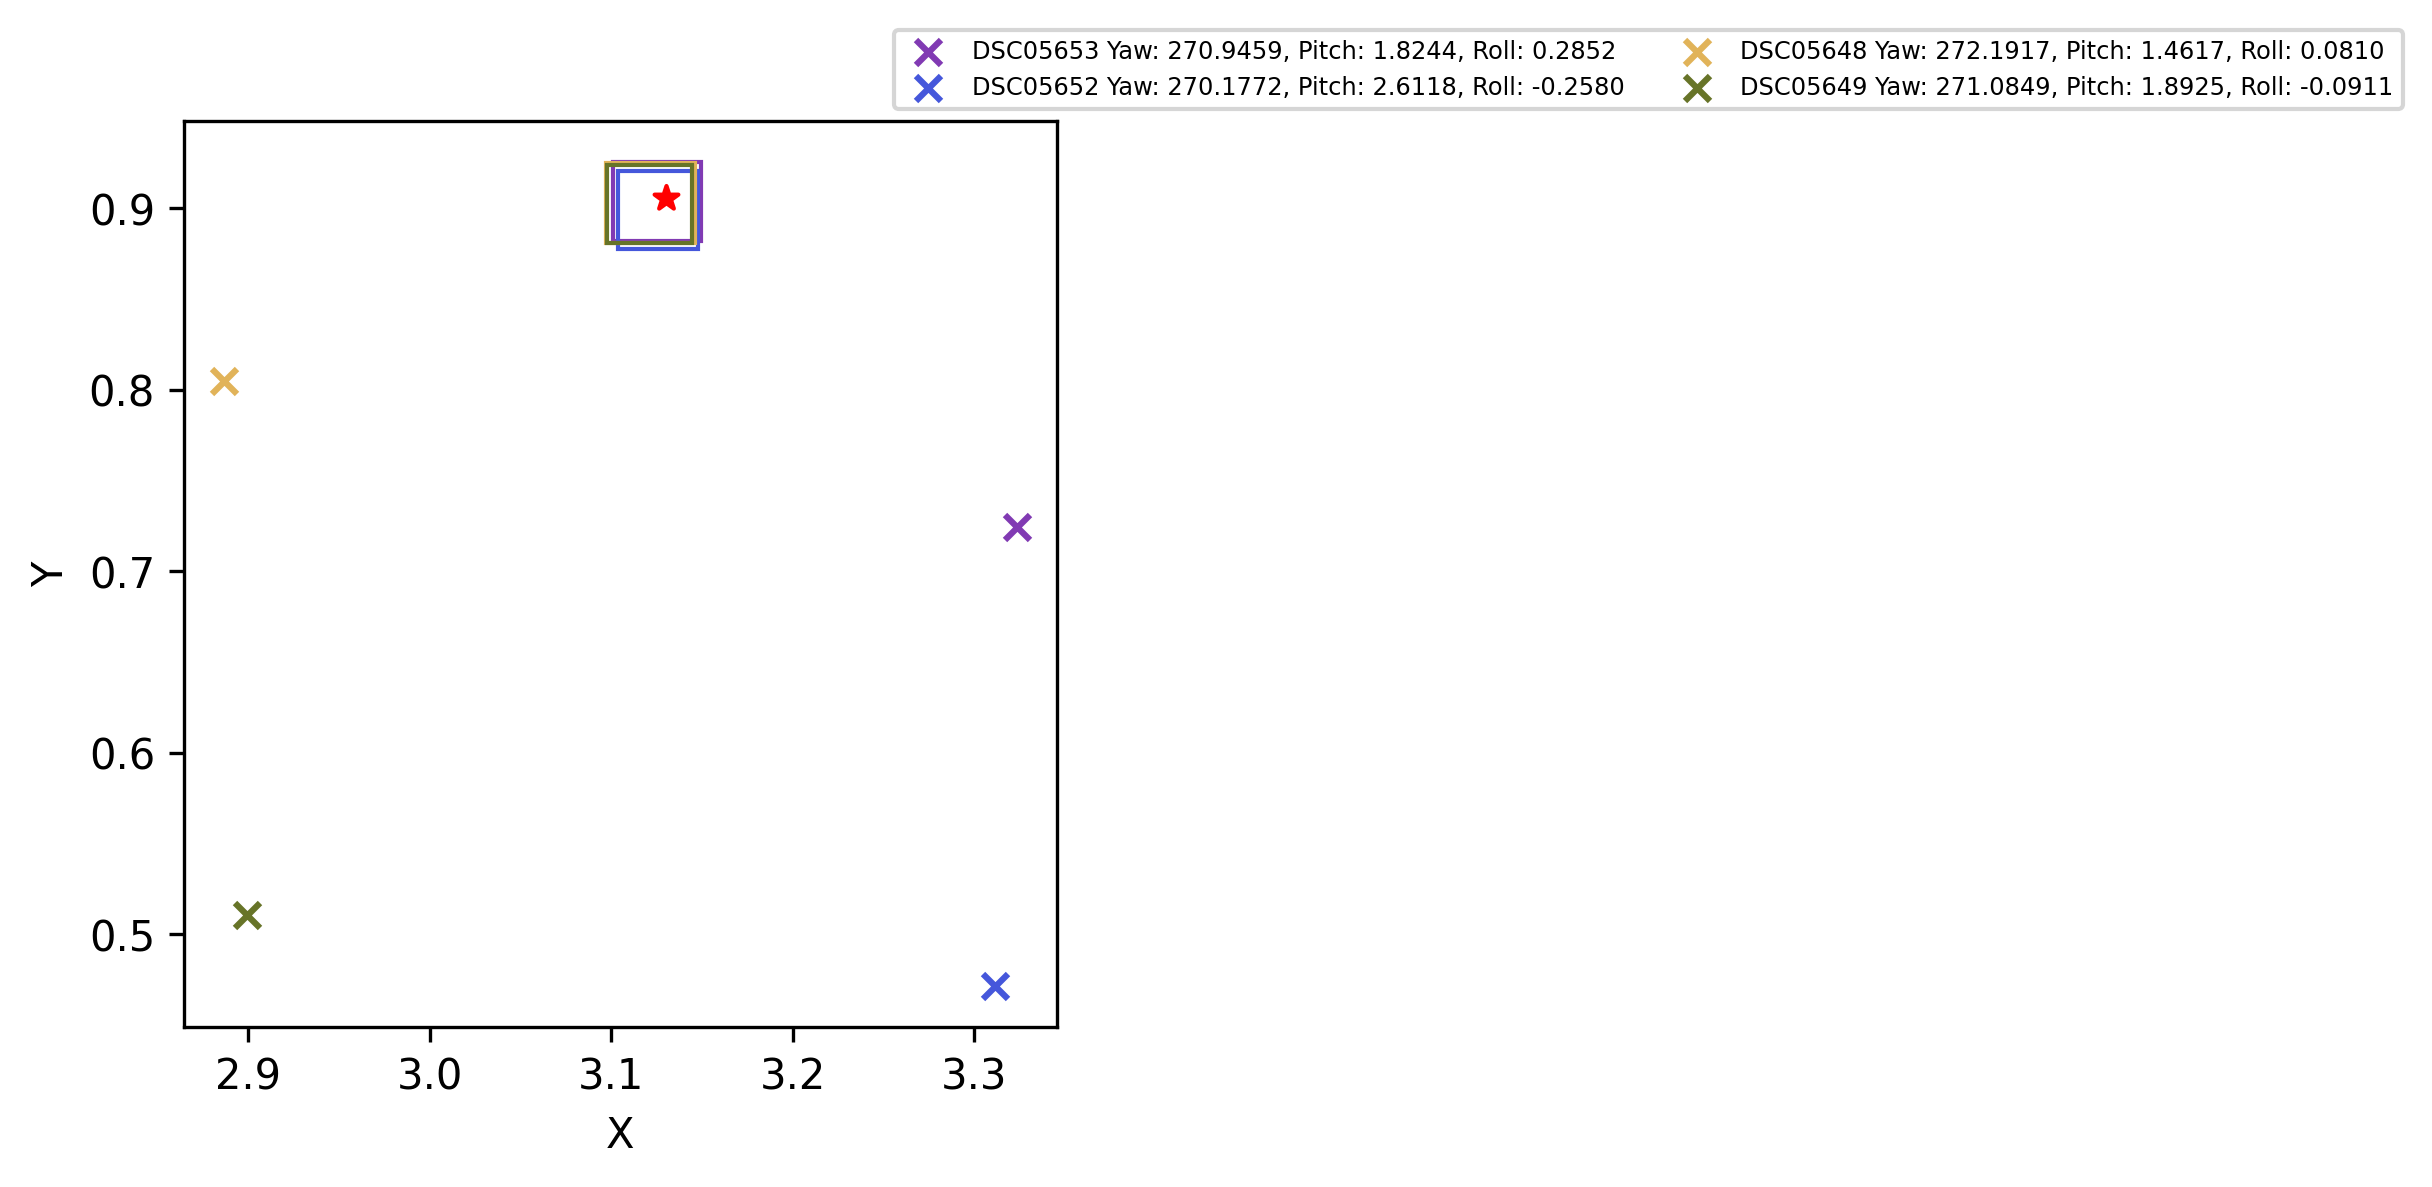

In [24]:
target_to_plot = "target 8"
plot_rectangle(camera_centers, inverse_results[target_to_plot], colors=["r", "g", "b"], targets=[target_store[target_to_plot]])

IOU - DSC05672, DSC05659: 0.48005492770414093
IOU - DSC05672, DSC05675: 0.3275434768393906
IOU - DSC05672, DSC05658: 0.5416445349847511
IOU - DSC05672, DSC05660: 0.5959207927091288
IOU - DSC05672, DSC05661: 0.4513659882058693
IOU - DSC05672, DSC05673: 0.8620670329312738
IOU - DSC05672, DSC05664: 0.4237078462210764
IOU - DSC05672, DSC05665: 0.8772923810627443
IOU - DSC05659, DSC05675: 0.5106439608780156
IOU - DSC05659, DSC05658: 0.8566274062906108
IOU - DSC05659, DSC05660: 0.7948848081315659
IOU - DSC05659, DSC05661: 0.6968858761328085
IOU - DSC05659, DSC05673: 0.4694586962065818
IOU - DSC05659, DSC05664: 0.22289455303036382
IOU - DSC05659, DSC05665: 0.5375193242563839
IOU - DSC05675, DSC05658: 0.47160012515820304
IOU - DSC05675, DSC05660: 0.4843711797494618
IOU - DSC05675, DSC05661: 0.7038104062442979
IOU - DSC05675, DSC05673: 0.297027733401024
IOU - DSC05675, DSC05664: 0.1515866545179497
IOU - DSC05675, DSC05665: 0.3660453751940965
IOU - DSC05658, DSC05660: 0.9054038691560226
IOU - DS

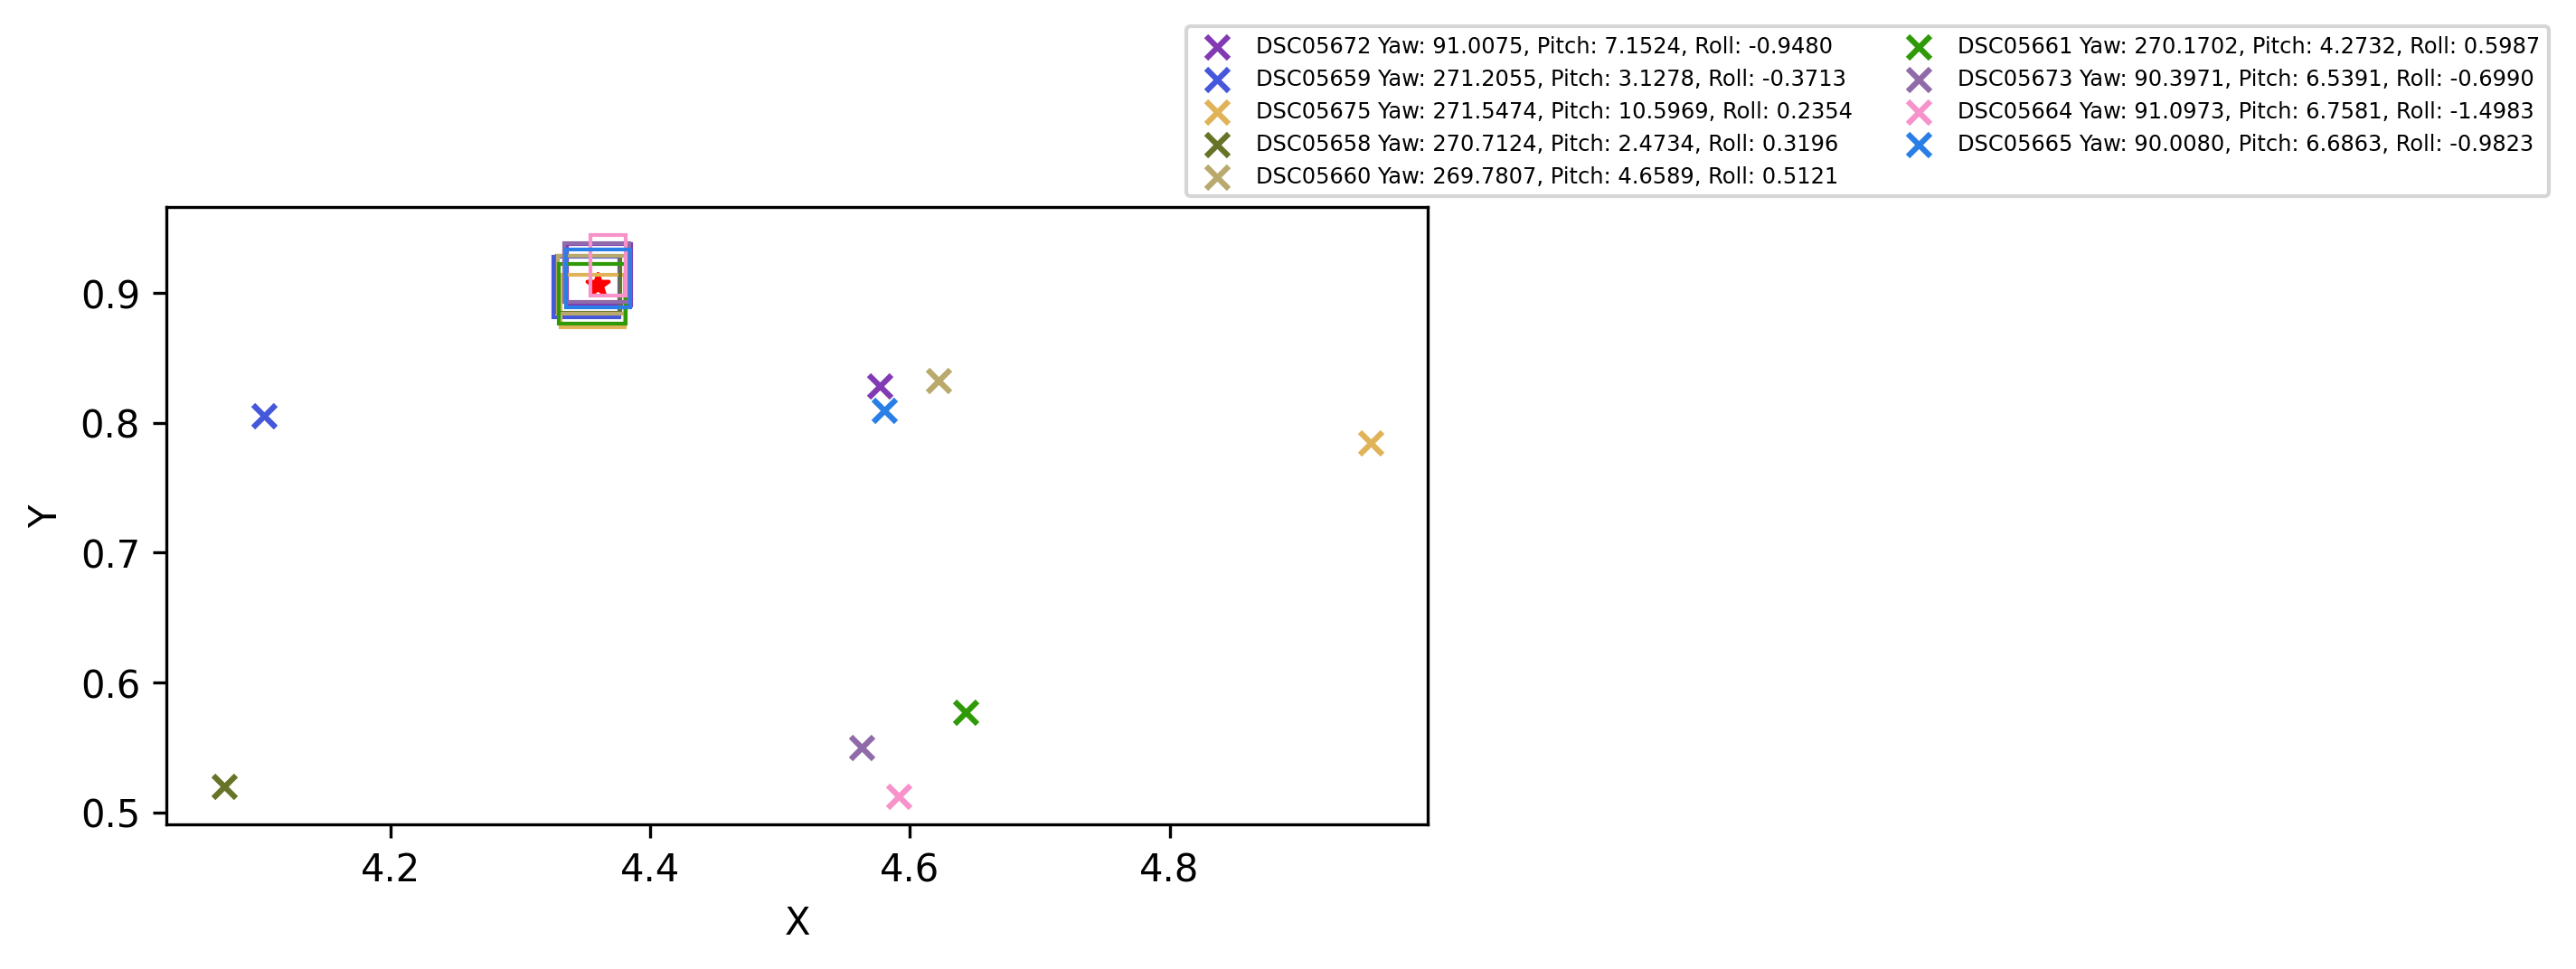

In [25]:
target_to_plot = "target 9"
plot_rectangle(camera_centers, inverse_results[target_to_plot], colors=["r", "g", "b"], targets=[target_store[target_to_plot]])

IOU - DSC05666, DSC05667: 0.5391994818573925
IOU - DSC05666, DSC05670: 0.9159425407721835
IOU - DSC05666, DSC05671: 0.85032326936426
IOU - DSC05667, DSC05670: 0.5669241461517739
IOU - DSC05667, DSC05671: 0.49082459369422027
IOU - DSC05670, DSC05671: 0.850589277892964


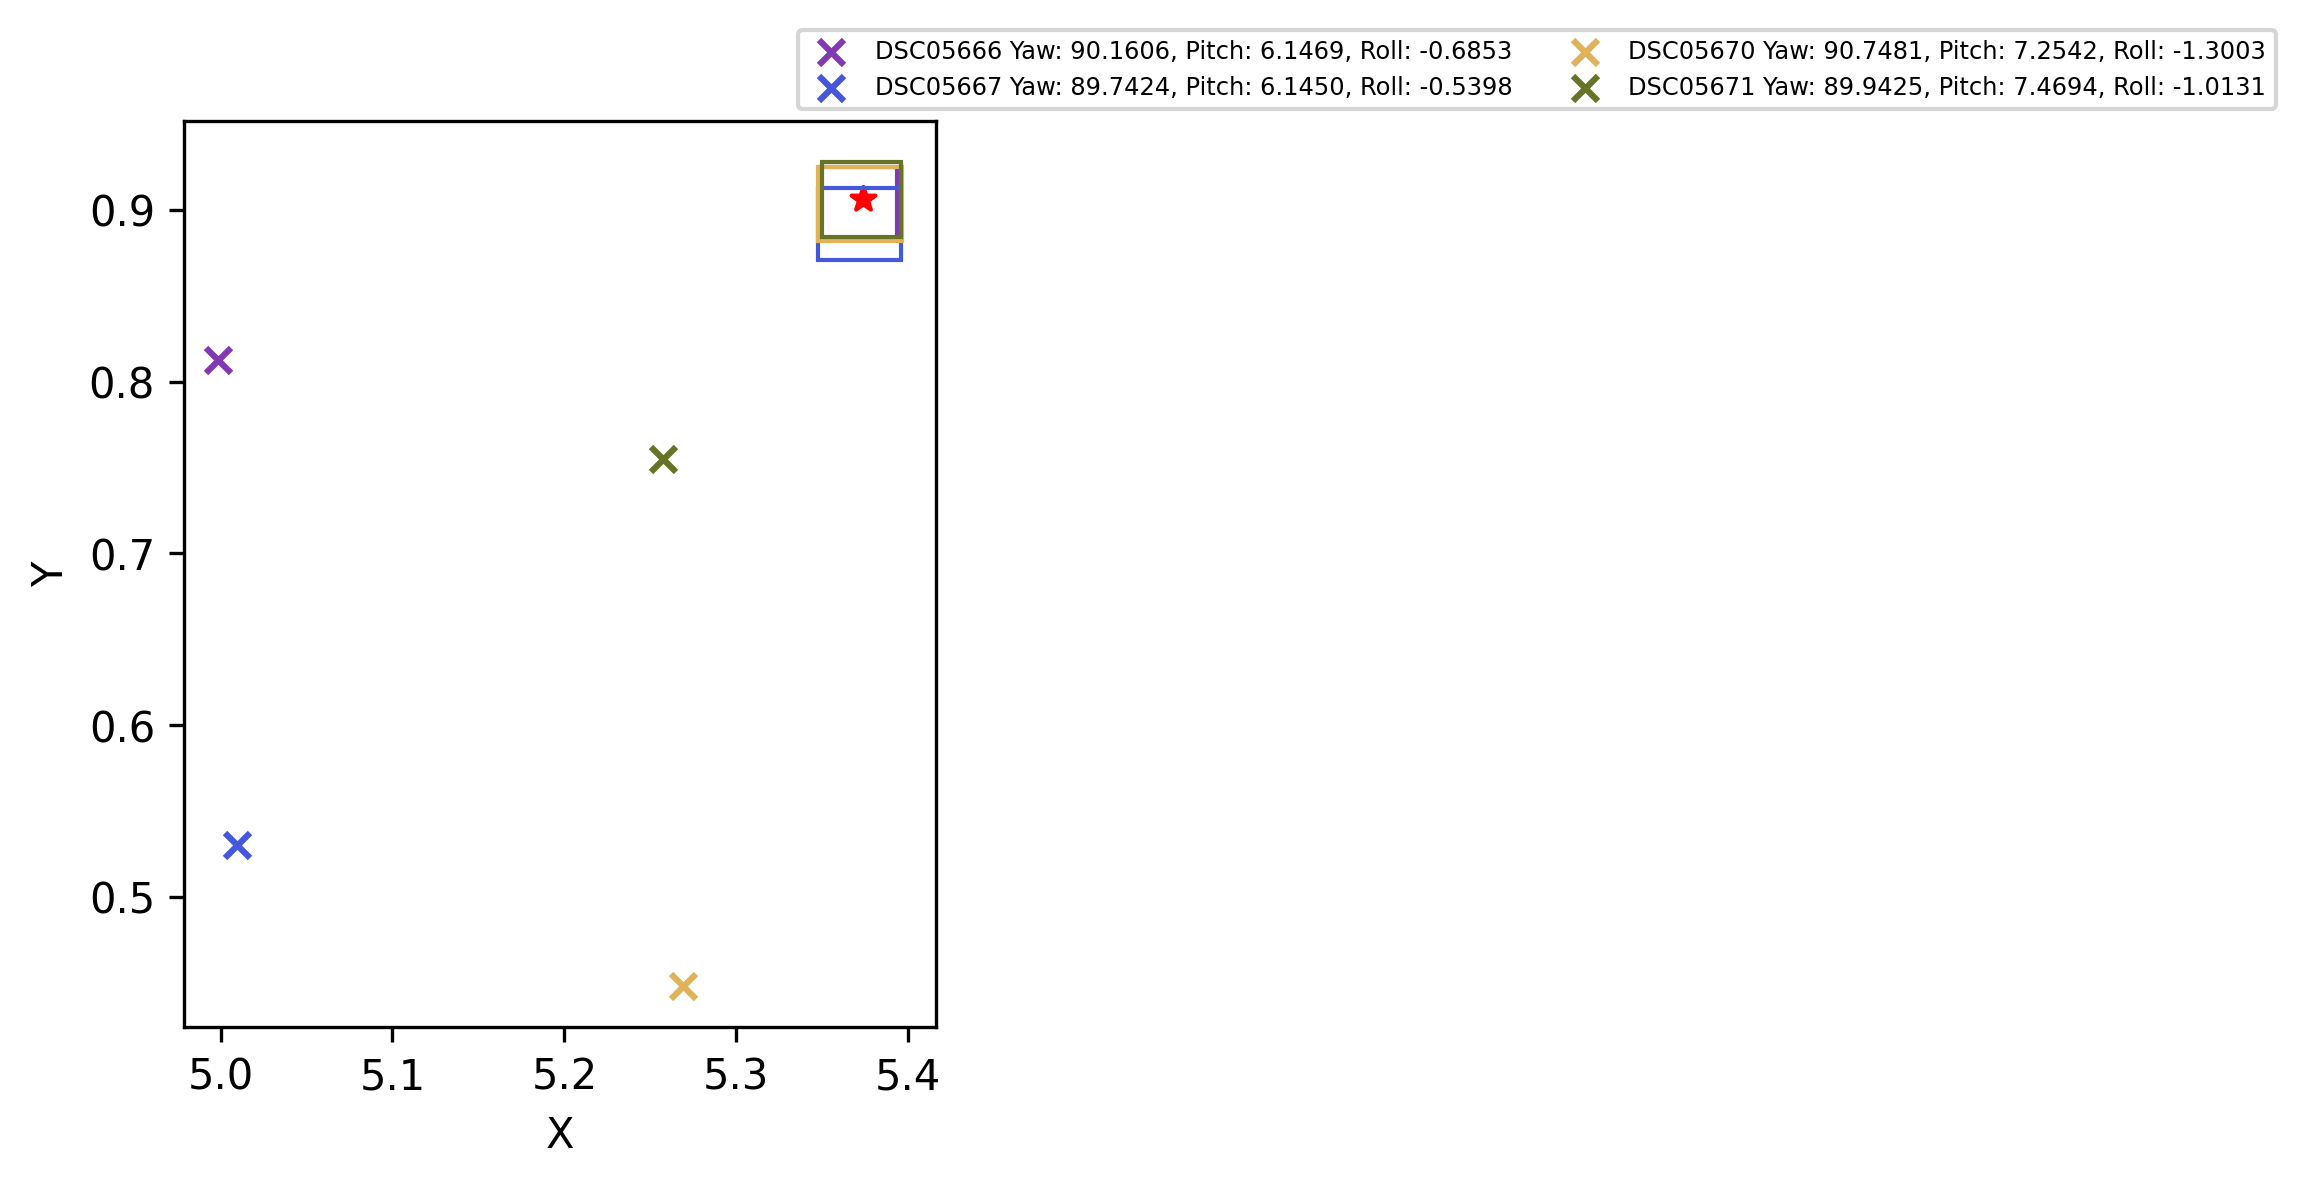

In [26]:
target_to_plot = "target 10"
plot_rectangle(camera_centers, inverse_results[target_to_plot], colors=["r", "g", "b"], targets=[target_store[target_to_plot]])